In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import torch
from sys import getsizeof
import matplotlib.pyplot as plt
from my_functions import FokkerPlankCalculator, get_pos, get_pos_with_border
from scipy.linalg import expm
from tqdm.notebook import tqdm
import yaml
from pathlib import Path
import pickle

# Time local equation --> Error

In [2]:
# Same as for escape dynamics
# #border = 0.002
# dt = 0.002
# k = 3
# max_t = 2
# #num_particle: 40000
# tau = 0
# D = 1e-6

# dx = 0.00002
# x_range = (-0.003,0.003)


# Same as in kroyProject
max_t = 2
avarage = 100
x_range = (-3e-3,3e-3)
dx = 0.00002
tau = 0.05#0.1
D = 1e-6
k = 10
dt = 1e-3 * 2

N_x = int(round((x_range[1] - x_range[0])/dx))+1
N_t = int(round(max_t/dt))+1
R = np.zeros((N_t, N_x, N_x))
data = np.zeros((N_t, N_x))
x_s = np.arange(x_range[0], x_range[1]+dx/2,dx)

In [3]:
data.shape

(1001, 301)

In [4]:
getsizeof(R)/1e6

725.532952

In [5]:
def get_D_w(D, max_t, dt, tau, k):
    my_fpc = FokkerPlankCalculator()
    s = np.sqrt(2*D)

    ts_all = np.arange(0, max_t+dt*5/4, dt/2)
    print(len(ts_all))
    ts = ts_all[::2]
    ts_ = ts_all[1::2]


    if tau > 0:
        max_p = int(max_t / tau) + 1
        print(max_p)
        l_data_all = my_fpc.l(k, tau, ts_all, max_p=max_p)
    else:
        l_data_all = np.exp(-k*ts_all)
    l_data = l_data_all[::2]
    l_data_ = l_data_all[1::2]

    w = my_fpc.get_w(l_data, l_data_, max_t)
    D_t_raw = my_fpc.get_D(l_data, l_data_, ts, max_t,D)
    return w, D_t_raw

In [6]:
w, D_t_raw = get_D_w(D, max_t, dt, tau, k)
D_t = D_t_raw #2*D_t_raw

2003
41


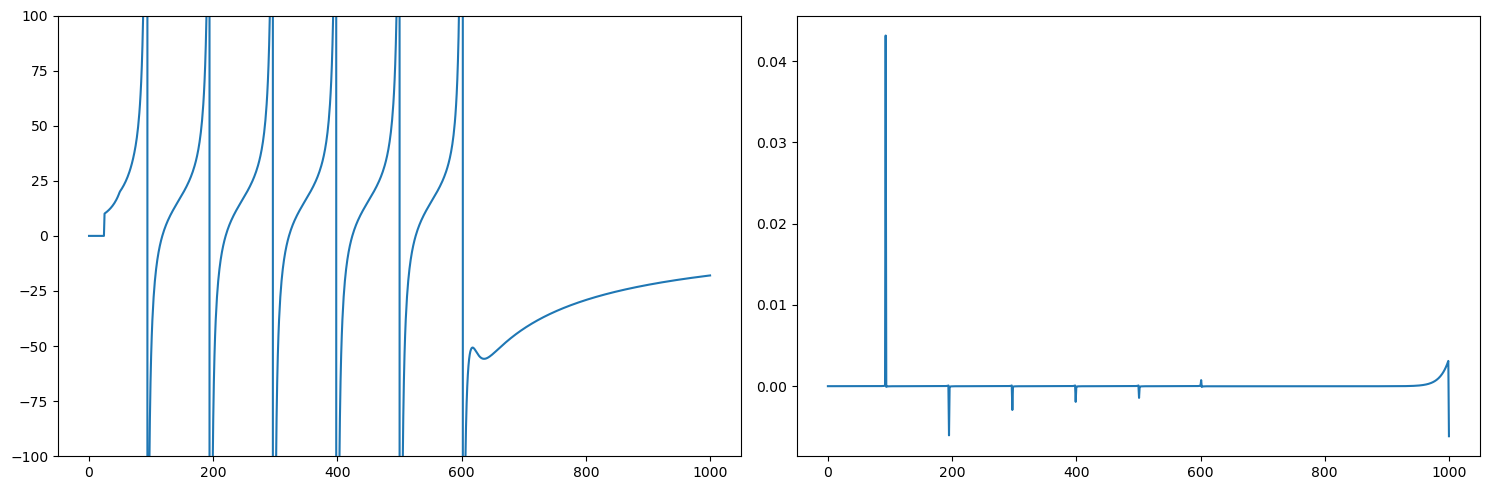

In [7]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(w)
axs[0].set_ylim(-100,100)
axs[1].plot(D_t)
plt.tight_layout()

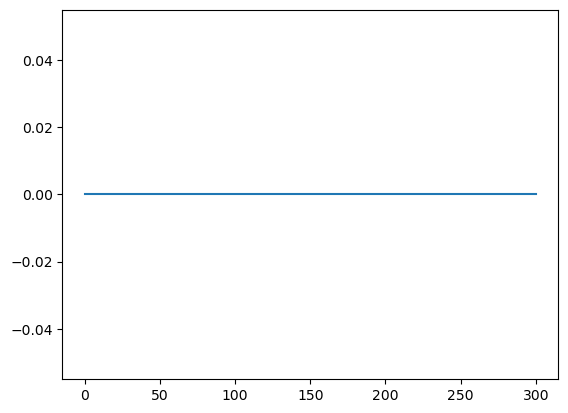

In [8]:
G = 0
U = (1/2*w[:,None]*x_s[None,:]**2 - G * x_s[None,:])/ D_t[:,None] 
plt.plot(U[0])

In [9]:
rip = D_t[:,None] / dx**2 * np.exp(-(U[:,1:]-U[:,:-1])/2) # r_i->i+1
rim = D_t[:,None] / dx**2 * np.exp(-(U[:,:-1]-U[:,1:])/2)  # r_i+1->i
R[:,0,0] = -rip[:,0]
R[:,-1,-1] = -rim[:,-1]
R[:,np.arange(1,300),np.arange(1,300)] = -(rip[:,1:]+rim[:,:-1]) # -(r_i->i+1 + r_i->i-1) ????
R[:,np.arange(0,300),np.arange(1,301)] = rim
R[:,np.arange(1,301),np.arange(0,300)] = rip
R.shape

(1001, 301, 301)

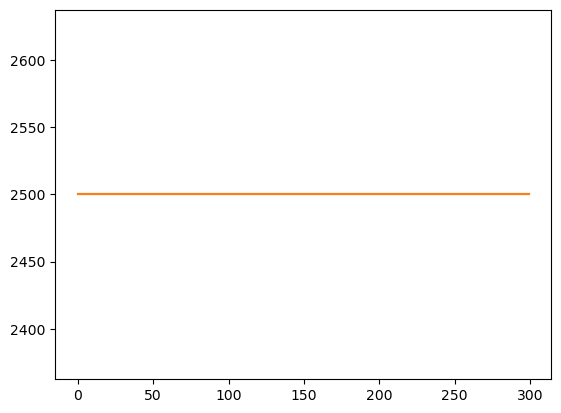

In [10]:
plt.plot(R[0,np.arange(1,301),np.arange(0,300)])
plt.plot(R[0,np.arange(0,300),np.arange(1,301)])

In [11]:
prop = np.stack([expm(o*dt) for o in R])

/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


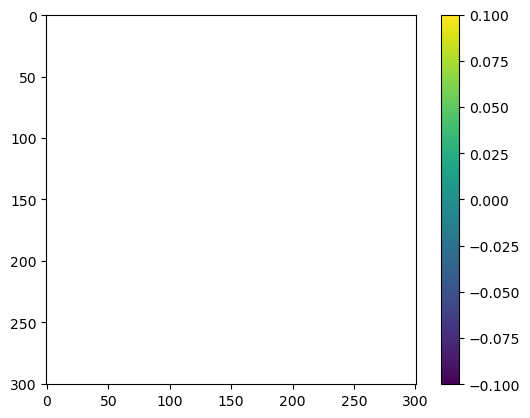

In [12]:
#plt.figure(figsize=(15,15))
plt.imshow(prop[-1])
plt.colorbar()

In [13]:
data[0,:] = 0
data[0,data.shape[1]//2] = 1

In [14]:
for i in range(1,len(data)):
    data[i] = prop[i-1]@data[i-1]

/tmp/ipykernel_30078/3961178829.py:2: RuntimeWarning: invalid value encountered in matmul
  data[i] = prop[i-1]@data[i-1]


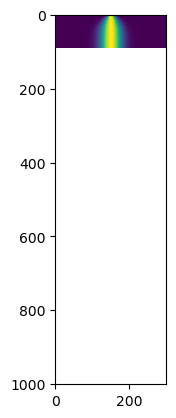

In [15]:
plt.imshow(data/data.max(axis=1)[:,None])

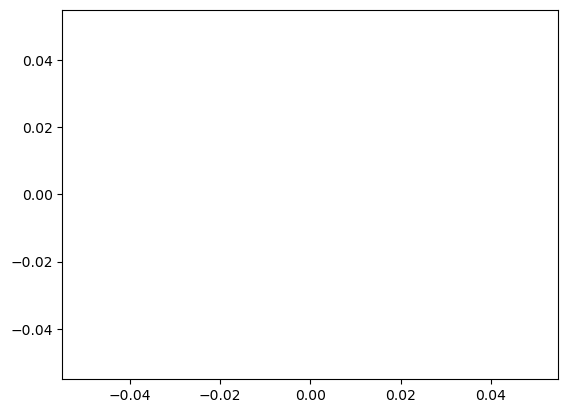

In [16]:
plt.plot(x_s,data[300])

# Itterative solution

In [16]:
class nummerical_solver():
    def get_solution(self,
                     max_t,
        x_range,
        dx,
        tau,
        D,
        k,
        dt,
        F_ext,
        boundary):
        
        
        F_ext = np.vectorize(F_ext)
        
        N_x = int(round((x_range[1] - x_range[0])/dx))+1
        N_t = int(round(max_t/dt))+1

        self.data = np.zeros((N_t, N_x))
        self.x_s = np.arange(x_range[0], x_range[1]+dx/2,dx)
        self.time = np.arange(0, max_t+dt/2,dt)
        self.D_t = np.zeros(N_t)
        self.effectiv_k = np.zeros(N_t)
        self.cond_var = np.zeros(N_t)
        self.variants = np.zeros(N_t)
        #self.corr_inv_tau = np.zeros(N_t)
        ntau = int(tau/dt)
        N_f = 1
        self.F = np.zeros((N_t,N_x, N_f))
        
        self.origindists = np.zeros((N_t,N_x,N_x))
        
        if tau == 0:
            self.D_t[:] = D #2*D
            self.F[:] = -1*k*self.x_s[None,:,None] + F_ext(self.time)[:,None,None]
            pF = np.array([1])
        else:
            self.D_t[:ntau] = D #2*D
            pF = np.array([1])
            self.F[:,:,:] = F_ext(self.time)[:,None,None]

        R = np.zeros((N_t, N_x, N_x,N_f))
        self.data[0,:] = 0
        self.data[0,np.argmin(self.x_s**2)] = 1/dx

        rip = np.zeros((N_t,N_x-1,N_f))
        rim = np.zeros((N_t,N_x-1, N_f))

        t_start = ntau if ntau > 0 else N_t
        ts = slice(0, t_start)

        rip[ts] = self.D_t[ts,None,None] / dx**2 * np.exp((self.F[ts,1:]*dx/self.D_t[ts,None,None])/2)  # r_i->i+1
        rim[ts] = self.D_t[ts,None,None] / dx**2 * np.exp(-(self.F[ts,1:]*dx/self.D_t[ts,None,None])/2)  # r_i+1->i
        if boundary == 'reflective':
            R[ts,0,0] = -rip[ts,0]
            R[ts,-1,-1] = -rim[ts,-1]
            R[ts,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[ts,1:]+rim[ts,:-1]) # -(r_i->i+1 + r_i->i-1) ????
            R[ts,np.arange(0,N_x-1),np.arange(1,N_x)] = rim[ts]
            R[ts,np.arange(1,N_x),np.arange(0,N_x-1)] = rip[ts]
        elif boundary == 'absorbing':
            R[ts,0,0] = -rip[ts,0]
            R[ts,-1,-1] = -rim[ts,-1]
            R[ts,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[ts,1:]+rim[ts,:-1]) # -(r_i->i+1 + r_i->i-1) ????
            R[ts,np.arange(0,N_x-1),np.arange(1,N_x)] = rim[ts]
            R[ts,np.arange(1,N_x-1),np.arange(0,N_x-2)] = rip[ts,:-1]

        self.prop = np.zeros((N_t,N_x,N_x))
        self.prop[:t_start] = np.stack([np.sum([expm(o[:,:,i]*dt) * pF[i] for i in range(o.shape[-1])], axis = 0) for o in R[ts]])

        initial_con_length = min(t_start+1, len(self.data))
        for i in range(1,initial_con_length):
            self.data[i] = self.prop[i-1]@self.data[i-1]
            
        mx = self.data[initial_con_length]*dx@self.x_s
        mx2 = self.data[:initial_con_length] *dx@ self.x_s**2
        self.variants[:initial_con_length] = mx2-mx**2

        for i in tqdm(range(t_start, N_t-1)):
            dm = self.data[i-ntau]
            dtprop = np.identity(N_x)
            dtprop_ = self.prop[i-ntau-1]
            for j in range(i-ntau,i):
                dtprop = np.matmul(self.prop[j],dtprop)
                dtprop_ = np.matmul(self.prop[j],dtprop_)
            absrates = dtprop * dm
            self.origindists[i] = absrates / absrates.sum(axis=1)[:,None]
            self.origindists[i][np.isnan(self.origindists[i])] = 0 #nan only behind boundary

          

            mx = self.origindists[i] @ self.x_s
            mx2 = self.origindists[i] @ self.x_s**2
            self.cond_var[i] = np.mean(mx2-mx**2)
            

            self.F[i] += -k * np.stack([mx]).T
            eff_k = - np.mean(np.diff(self.F[i], axis=0)) /dx
            self.effectiv_k[i] = eff_k
          
            
         
            if self.effectiv_k[i-ntau]+self.effectiv_k[i] == 0:
                self.D_t[i] = D
            else:
                self.D_t[i] = D + 1/2*self.cond_var[i]*k**2 * 1/(self.effectiv_k[i-ntau]+self.effectiv_k[i])

            rip[i] = self.D_t[i,None,None] / dx**2 * np.exp( (self.F[i,1:] * dx / self.D_t[i,None,None])/2)  # r_i->i+1
            rim[i] = self.D_t[i,None,None] / dx**2 * np.exp(-(self.F[i,1:] * dx / self.D_t[i,None,None])/2)  # r_i+1->i

            if boundary == 'reflective':
                R[i,0,0] = -rip[i,0]
                R[i,-1,-1] = -rim[i,-1]
                R[i,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[i,1:]+rim[i,:-1]) # -(r_i->i+1 + r_i->i-1) ????
                R[i,np.arange(0,N_x-1),np.arange(1,N_x)] = rim[i]
                R[i,np.arange(1,N_x),np.arange(0,N_x-1)] = rip[i]
            elif boundary == 'absorbing':
                R[i,0,0] = -rip[i,0]
                R[i,-1,-1] = -rim[i,-1]
                R[i,np.arange(1,N_x-1),np.arange(1,N_x-1)] = -(rip[i,1:]+rim[i,:-1]) # -(r_i->i+1 + r_i->i-1) ????
                R[i,np.arange(0,N_x-1),np.arange(1,N_x)] = rim[i]
                R[i,np.arange(1,N_x-1),np.arange(0,N_x-2)] = rip[i,:-1]

            self.prop[i] = np.sum([expm(R[i,:,:,j]*dt) * pF[j] for j in range(R[i].shape[-1])], axis = 0)
            self.data[i+1] = self.prop[i]@self.data[i]
            mx = self.data[i+1]*dx@self.x_s
            mx2 = self.data[i+1] *dx@ self.x_s**2
            self.variants[i+1] = mx2-mx**2
            
        self.num_paarticles = self.data.sum(1)
        self.rate = -np.diff(self.num_paarticles)/self.num_paarticles[1:]/dt
        return self.data

In [29]:
max_t = 4
#avarage = 100
x_range = (-4e-3,4e-3)
dx = 0.00004
tau = 0.3 #0.3 #0.1 #0.05#0.1
D = 1e-6
k = 3
dt = 1e-3 * 4


F_ext = lambda t:0

boundary = 'reflective' #'absorbing'

In [30]:
solver = nummerical_solver()
data = solver.get_solution(max_t = max_t,
    x_range = x_range,
    dx = dx,
    tau = tau,
    D = D,
    k = k,
    dt = dt,
    F_ext = F_ext,
    boundary = boundary)

  0%|          | 0/925 [00:00<?, ?it/s]

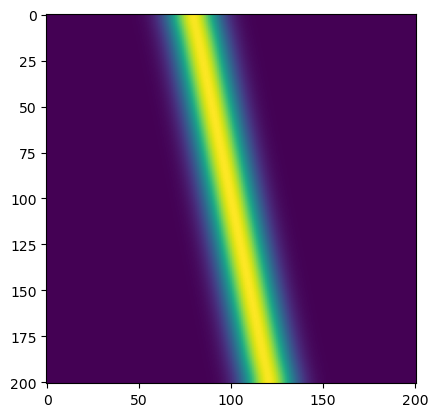

In [31]:
plt.imshow(solver.origindists[100])

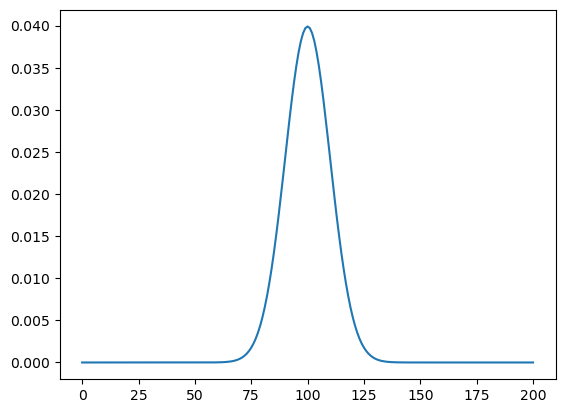

In [32]:
plt.plot(solver.origindists[100][100])

In [33]:
#plt.plot(solver.corr_inv_tau)
#plt.xlim(70,200)

In [34]:
#plt.figure(figsize=(15,15))
#plt.imshow(solver.prop[2])
#plt.colorbar()

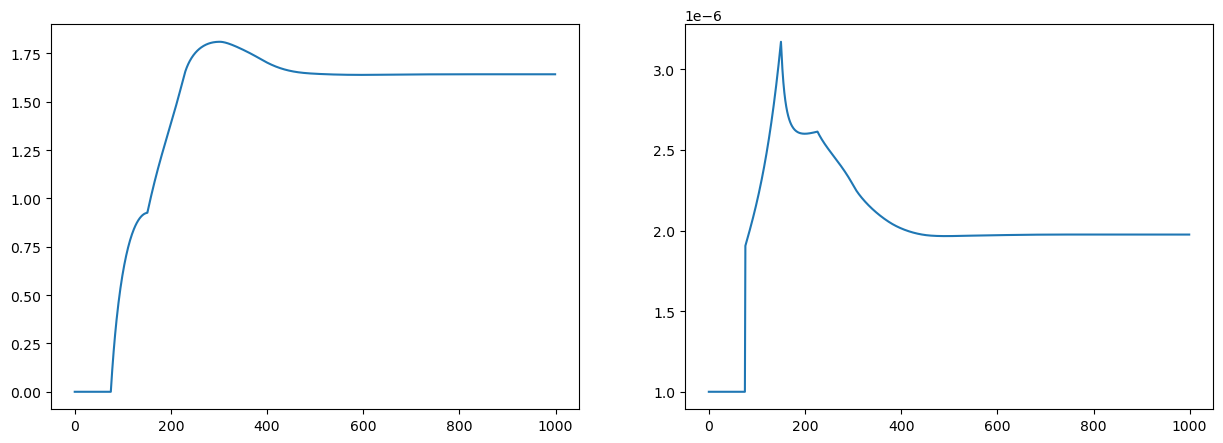

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(solver.effectiv_k[:-1])
#plt.xlim(0,50)
plt.subplot(122)
plt.plot(solver.D_t[:-1])
#plt.xlim(0,50)

In [36]:
np.mean( solver.effectiv_k[200:-1])

1.6664517810838626

In [37]:
# Compare
ntau = int(tau/dt)
x_s = np.arange(x_range[0], x_range[1]+dx/2,dx)
num_particle = 40_000

if boundary == 'reflective':
    pos = get_pos(
            num_particle=num_particle,
            max_t = max_t+tau,
            dt = dt,
            tau=tau,
            k=k,
            D=D,
            F=lambda t:0)[ntau:]
elif boundary == 'absorbing':
    pos = get_pos_with_border(
            border = x_range[1]-dx,
            num_particle=num_particle,
            max_t = max_t+tau,
            dt = dt,
            tau=tau,
            k=k,
            D=D,
            F=lambda t:0)[ntau:]
    
    
hists = np.stack([np.histogram(o, bins=x_s)[0]/num_particle*1/dx for o in pos])
sim_num_particle = hists.sum(1)
sim_rate = -np.diff(sim_num_particle)/sim_num_particle[1:]/dt

75


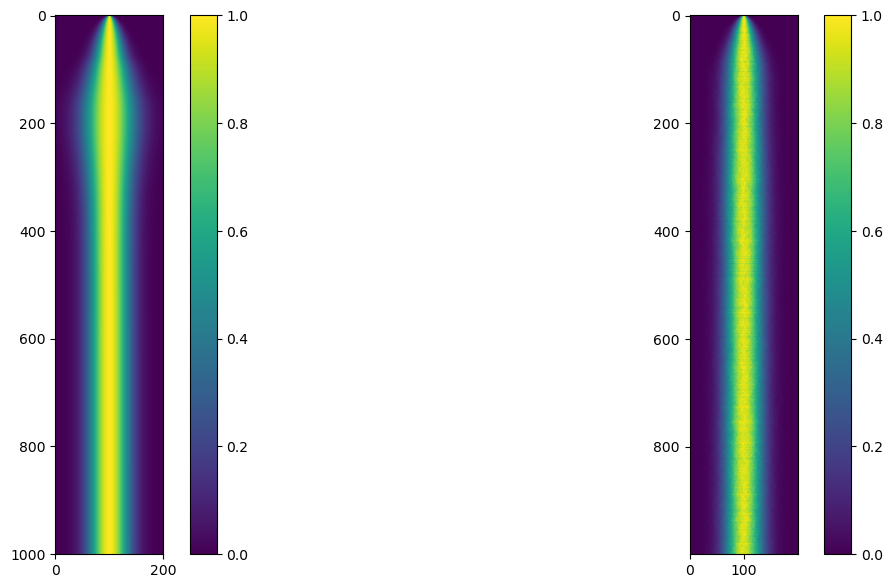

In [38]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
ims1 = axs[0].imshow(data/data.max(axis=1)[:,None])
plt.colorbar(ims1, ax=axs[0])

ims2 = axs[1].imshow(hists/hists.max(axis=1)[:,None])
plt.colorbar(ims2, ax=axs[1])

In [39]:
sim_var = torch.var(pos[:,:,0], axis = 1)

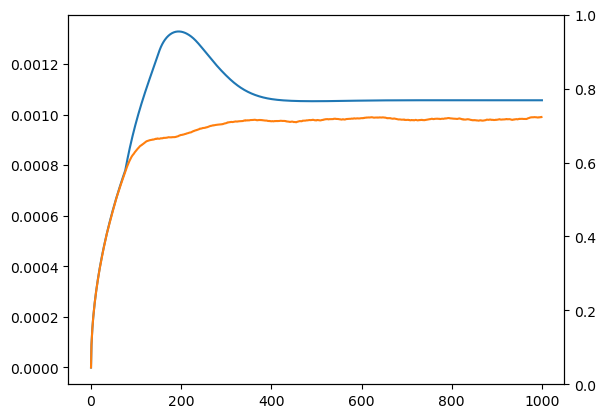

In [40]:
fig, axs = plt.subplots(1,1)
axs.plot(np.sqrt(solver.variants))
axs.plot(np.sqrt(sim_var))

axs2 = axs.twinx()
#axs2.plot(solver.effectiv_k[:-1], color='C2')
#axs2.plot(solver.D_t[:-1], color='C3')

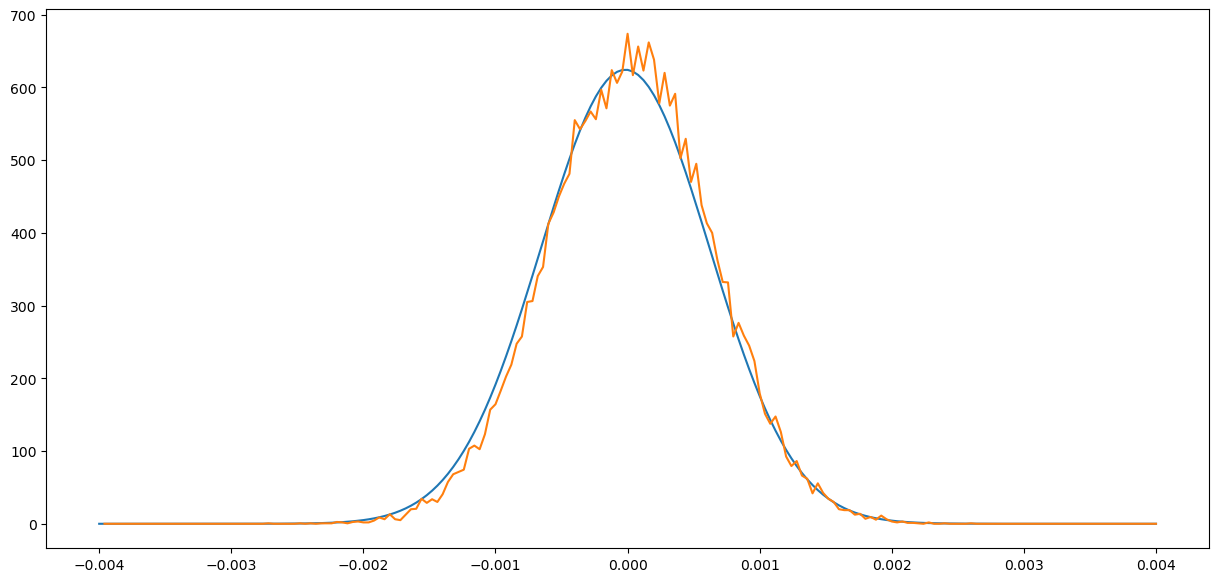

In [14]:
idx = 900
plt.figure(figsize=(15,7))
plt.plot(x_s,data[idx])
plt.plot(x_s[1:], hists[idx])
#plt.plot(x_s,dtprop[N_x//2]*1/dx)

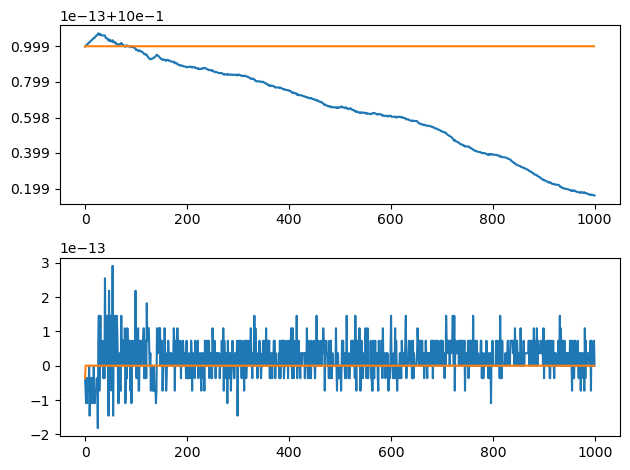

In [69]:
plt.subplot(211)
plt.plot(solver.num_paarticles *dx)
plt.plot(sim_num_particle *dx)

plt.subplot(212)
plt.plot(solver.rate)
plt.plot(sim_rate)

plt.tight_layout()

## Use for forces

In [49]:
folder = Path.cwd()/'nummeric_results/tau03/'
with open(folder/'std_parameter_setting.yaml') as file:
    settings = yaml.load(file, Loader= yaml.SafeLoader)
    
dx = 3*settings['border']/200

forces = {
    "no": lambda i: 0,
    "const": lambda i:2e-3,
    "ramp": lambda i: 0.005*i/(settings['max_t']),
    "oszi": lambda i: 0.005*np.cos(i * 10)
}
sim_res = {}

In [50]:
settings

{'name': 'tau03',
 'border': 0.002,
 'dt': 0.001,
 'k': 3,
 'max_t': 2,
 'num_particle': 40000,
 'tau': 0.3,
 'D': '1e-6'}

In [51]:
solver = nummerical_solver()

In [52]:
for key in tqdm(forces):
    data = solver.get_solution(max_t = settings['max_t'],
        x_range = (-2*settings['border'],settings['border']+dx),
        dx = dx,
        tau = settings['tau'],
        D = float(settings['D']),
        k = settings['k'],
        dt = settings['dt'],
        F_ext = forces[key],
        boundary = 'absorbing')

    sim_res[key] = solver.rate

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1700 [00:00<?, ?it/s]

/tmp/ipykernel_65293/2659481362.py:78: RuntimeWarning: invalid value encountered in divide
  origindists = absrates / absrates.sum(axis=1)[:,None]


  0%|          | 0/1700 [00:00<?, ?it/s]

  0%|          | 0/1700 [00:00<?, ?it/s]

  0%|          | 0/1700 [00:00<?, ?it/s]

In [53]:
with open(folder/'num_res.pkl','wb') as f:
    pickle.dump(sim_res, f)

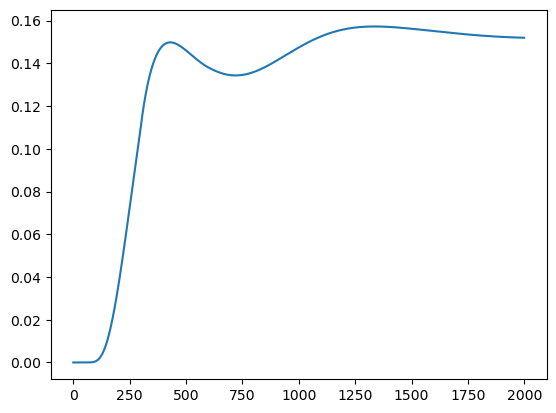

In [54]:
plt.plot(sim_res['no'])
#plt.ylim(0.0075, 0.008)

# Tests

-5 -1 : -1.501
-1 1 : 0.0
1 5 : 1.501


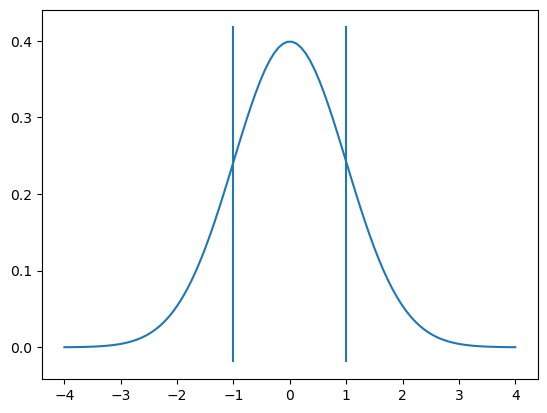

In [44]:
x = np.linspace(-4,4,100)
y = 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)
plt.plot(x,y)
plt.vlines((-1,1),*plt.ylim())

intvb = [-5,-1,1,5]
for (f,t) in zip(intvb[:-1], intvb[1:]):
    idxs = (x > f) * (x < t)
    m = (x[idxs]*y[idxs] / y[idxs].sum()).sum()
    print(f,t,':',round(m,3))